The goal of this notebook is to create a Russian version of mT5 model out of the multilingual one. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/idt5_base

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/idt5_base


In [ ]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 23.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.6 MB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.6 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Removing the unused vocabulary

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/mt5-base")
tokenizer

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='google/mt5-base', vocab_size=250100, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('google/mt5-base')

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Our tokenizer contains 250K tokens, 

In [ ]:
print(tokenizer.vocab_size)

250100


The model has 582M parameters. 

In [ ]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.shared))
print('encoder')
print(msize(model.encoder))
print(msize(model.encoder.block))
print('decoder')
print(msize(model.decoder))
print(msize(model.decoder.block))
print(msize(model.lm_head))

582401280
192086016
encoder
277040256
84953472
decoder
305361024
113274240
192086016


Input and output embeddings are 66% of the whole model

In [ ]:
print(msize(model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))

0.32981729710484153
0.32981729710484153


# Determine the new tokens

Take a file from https://wortschatz.uni-leipzig.de/en/download/Russian as a representation of Russian language. It contains 1M sentences. 

Also take a similar representation of English, because we want our model to be bilingual, and English shares few tokens with Russian.

In [ ]:
!wget https://pcai056.informatik.uni-leipzig.de/downloads/corpora/ind-id_web-public_2017_1M.tar.gz
!tar -xsvf ind-id_web-public_2017_1M.tar.gz

--2022-06-07 03:10:09--  https://pcai056.informatik.uni-leipzig.de/downloads/corpora/ind-id_web-public_2017_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223041490 (213M) [application/x-gzip]
Saving to: ‘ind-id_web-public_2017_1M.tar.gz’

ind-id_web-public_2 100%[===================>] 212.71M  26.0MB/s    in 9.3s    

2022-06-07 03:10:19 (22.9 MB/s) - ‘ind-id_web-public_2017_1M.tar.gz’ saved [223041490/223041490]

ind-id_web-public_2017_1M/
ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-words.txt
ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-co_s.txt
ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-inv_so.txt
ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-sentences.txt
ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-co_n.txt
ind-id_web-

In [ ]:
!wget https://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
!tar -xsvf eng-com_web-public_2018_1M.tar.gz

--2022-06-07 03:10:39--  https://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng-com_web-public_2018_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228887647 (218M) [application/x-gzip]
Saving to: ‘eng-com_web-public_2018_1M.tar.gz’

eng-com_web-public_ 100%[===================>] 218.28M  27.8MB/s    in 9.6s    

2022-06-07 03:10:49 (22.6 MB/s) - ‘eng-com_web-public_2018_1M.tar.gz’ saved [228887647/228887647]

eng-com_web-public_2018_1M/
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-co_s.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-inv_so.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-words.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sentences.txt
eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-source

Let us look at the sentences

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
fname = 'ind-id_web-public_2017_1M/ind-id_web-public_2017_1M-sentences.txt'
df_id = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_id.columns = ['idx', 'text']
df_id.sample(5)

,idx,text
938821,938822,"Tidak mungkin orang berangkat ke luar negeri sekonyong-konyong gitu, semua melalui proses."
70033,70034,"Bahan yang yang digunakan adalah 200 ml air kelapa, dua buah jeruk peras, 50 gram gula pasir, dan satu gelas daging kelapa dan es batu."
503577,503578,"Materi diklat ini berkisar pada pembuatan konten e-Learning dengan Moodle sebagai Learning Management System, sampai dengan simulasi dan bagaimana cara mengorganisasi pembelajaran e-Learning."
191830,191831,Dengan melakukan sesi latihan otot juga akan membuat badan kurus Anda menjadi lebih terlihat kencang dan berotot.
866686,866687,"Setiap pagi jam lima, dan setiap sore jam empat, Raden sudah duduk di atas jok motornya dan menanti kedatangan Irama untuk diantarkan ke kampus atau rumahnya."


In [ ]:
fname = 'eng-com_web-public_2018_1M/eng-com_web-public_2018_1M-sentences.txt'
df_en = pd.read_csv(fname, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
690733,690734,"Taste the mixture, adding a bit more of whatever you feel is lacking."
271020,271021,"Her tips and recipe roundups are super-practical for vegans and non-vegans alike."""
907096,907097,We had disable room.
364554,364555,I’m not sure if you meant to say Glycogenesis (with a ‘y’) or Glucogenesis.
361177,361178,"I’m equal parts Clarice, Lois, and Stuart!"


Count the tokens that the current model uses for representing the sentences. 

In [ ]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_id = Counter()
for text in tqdm(df_id.text):
    cnt_id.update(tokenizer.encode(text))

cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
cnt_en = Counter()
for text in tqdm(df_en.text):
    cnt_en.update(tokenizer.encode(text))

The tokens that are ever used with Indonesian are 28% of the whole vocabulary. With English, it is 27%.

Surprisingly, there is more than 76% overlap between the vocabularies. Perhaps, this is because in Indonesian texts there are occasionally English words or other words with latin alphabet. 

In [ ]:
print(len(cnt_id), len(cnt_id)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
common = len(set(cnt_id.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_id))

71879 0.28740103958416635
67920 0.2715713714514194
54719 0.761265460009182


For both English and Russian, 10K tokens cover about 95% of the vocabulary, and 20K - about 98%. 

In [ ]:
print('id')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_id.most_common(top)) / sum(cnt_id.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))

id
10000 0.9655725952396591
20000 0.9874619390208553
30000 0.994310026842242
en
10000 0.9531899764307693
20000 0.9840809828270257
30000 0.9937869259525808


Remember the old vocabulary, because we are going to replace it soon!

In [ ]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [ ]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_id.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))

['▁', '</s>', '.', ',', '▁di', '▁yang', '▁dan', 'an', 'kan', '▁se', 'nya', '-', '▁dengan', '▁ini', 'i', '▁ke', 's', 'a', '▁ber', '▁untuk', '▁ter', '▁me', '▁dari', '▁dalam', '▁meng', 'si', '▁b', '▁(', '▁per', 't']
['▁', '</s>', '.', '▁the', ',', 's', '▁to', '▁and', 'a', '▁of', '▁in', '▁is', '▁I', '’', '▁that', 'ed', '▁for', '-', 'ing', "'", '▁you', '▁it', '▁with', '▁on', 'ly', 'y', '▁be', '▁The', '▁as', '▁are']


We try the following composition of vocabulary:
* 1K of top tokens of the original tokenizer (just in case)
* Top 10K of the English vocabulary
* Top 20K of the Russian vocabulary (or more, to make the total number of tokens 30K)
* 100 special tokens that T5 uses


In [ ]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_en.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)
for i, (k, v) in enumerate(cnt_id.most_common(25_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Indonesian tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)

print(len(new_tokens))
kept_ids = sorted(new_tokens)

24471 Indonesian tokens are included
30000


The new vocabulary is only 12% of the original one. 

In [ ]:
len(kept_ids) / tokenizer.vocab_size

0.11995201919232307

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward). 

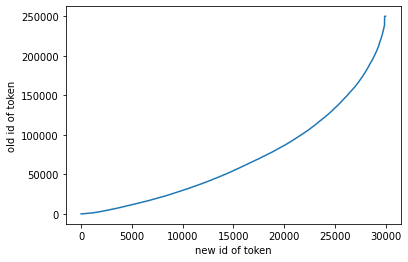

In [ ]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [ ]:
import torch

In [ ]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [ ]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [ ]:
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

The new model has 244M parameters - 42% of the original size. 

In [ ]:
print(msize(model), msize(model) / original_size)

244309248 0.4194861110195362


### Update the tokenizer

T5 uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python. 

Fortunately, we can download its model and deploy it into Python using its Protobuf representation. 

https://github.com/google/sentencepiece/issues/121

In [ ]:
!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2022-06-07 03:35:44--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451 (13K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.14K  --.-KB/s    in 0.003s  

2022-06-07 03:35:44 (5.03 MB/s) - ‘sentencepiece_model.proto’ saved [13451/13451]



We compile the protobuf description of the sentencepiece model in order to be able to modify it. 

In [ ]:
! protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class. 

In [ ]:
import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))

# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 30000


  0%|          | 0/220100 [00:00<?, ?it/s]

30000


In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)

### Save the model

In [ ]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'muchad/idt5-base'
model.config

T5Config {
  "_name_or_path": "muchad/idt5-base",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.19.2",
  "use_cache": true,
  "vocab_size": 30000
}

In [ ]:
new_tokenizer.save_pretrained('idt5-base')
model.save_pretrained('idt5-base')

In [ ]:
!ls idt5-base -alsh

total 933M
1.0K -rw------- 1 root root  742 Jun  7 03:47 config.json
933M -rw------- 1 root root 933M Jun  7 03:48 pytorch_model.bin
 512 -rw------- 1 root root   65 Jun  7 03:47 special_tokens_map.json
738K -rw------- 1 root root 738K Jun  7 03:47 spiece.model
 512 -rw------- 1 root root  173 Jun  7 03:47 tokenizer_config.json


Now try to load the model

In [ ]:
model1 = T5ForConditionalGeneration.from_pretrained('idt5-base')
tokenizer1 = T5Tokenizer.from_pretrained('idt5-base')

The model has not been fine-tuned on any sensible task except filling the gaps. And even this task is performed strangely - the models continues generating when it should have stopped. 

But we hope that after fine-tuning it will be better. But this is the topic of the next story)

In [ ]:
inputs = tokenizer1('The <extra_id_0> walks in <extra_id_1> park.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0> former <extra_id_1> the <extra_id_2> the <extra_id_3> former <extra_id_4> town in our <extra_id_5> national park</s>
<pad> <extra_id_0> streets are <extra_id_1> the <extra_id_2> this country <extra_id_21>Ease</s> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> countryside <extra_id_1> the <extra_id_2> a...</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
inputs = tokenizer1('<extra_id_0> jalan-jalan di taman <extra_id_1>.', return_tensors='pt')
with torch.no_grad():
    hypotheses = model1.generate(
        **inputs, 
        do_sample=True, top_p=0.95, 
        num_return_sequences=3, 
        repetition_penalty=2.5,
        max_length=32,
    )
for h in hypotheses:
    print(tokenizer1.decode(h))

<pad> <extra_id_0>. <extra_id_1> memang best <extra_id_2> dan jalan.</s> <pad> <pad> <pad>
<pad> <extra_id_0> untuk <extra_id_1>-rumah <extra_id_2> tersebut <extra_id_3> hingga di mana.</s>
<pad> <extra_id_0> anda <extra_id_1> di mana <extra_id_2>, tak pa!</s> <pad> <pad> <pad>


I will save the model on my Google drive to retrieve it later for fine-tuning. 

In [ ]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [ ]:
model1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')
tokenizer1.save_pretrained('/gd/MyDrive/models/rut5-base-raw')

('/gd/MyDrive/models/rut5-base-raw/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-raw/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-raw/spiece.model',
 '/gd/MyDrive/models/rut5-base-raw/added_tokens.json')

In [ ]:
zip -r /content/new-model.zip /content/new-model